In [1]:
import warnings
import torch
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
import numpy as np

In [2]:
df_train = pd.read_csv('data/twitter_training.csv', header=None, names=["id", "company", "sentiment", "text"])
df_val = pd.read_csv('data/twitter_validation.csv', header=None, names=["id", "company", "sentiment", "text"])
print(len(df_train), len(df_val))
df_val.head()

74682 1000


,id,company,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [3]:
valid_sentiments = {"Negative", "Neutral", "Positive"}

df_train = df_train[df_train["sentiment"].isin(valid_sentiments)]
df_val = df_val[df_val["sentiment"].isin(valid_sentiments)]

label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_train["label"] = df_train["sentiment"].map(label_map).astype(int)
df_val["label"] = df_val["sentiment"].map(label_map).astype(int)

df_train["text"] = df_train["text"].astype(str)
df_val["text"] = df_val["text"].astype(str)

In [4]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

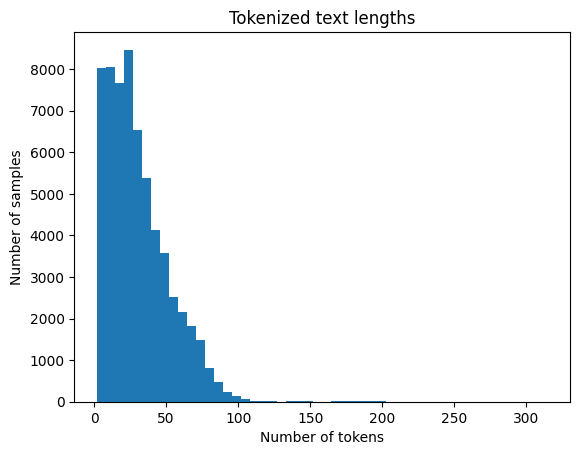

Mean: 30.707757894054335
95-percentile: 72.0
Max: 315


In [5]:
lengths = [len(tokenizer.encode(text, truncation=False)) for text in df_train["text"]]

plt.hist(lengths, bins=50)
plt.title("Tokenized text lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Number of samples")
plt.show()

print("Mean:", np.mean(lengths))
print("95-percentile:", np.percentile(lengths, 95))
print("Max:", np.max(lengths))

In [6]:
SEQ_LENGTH = 64

train_encodings = tokenizer(df_train["text"].tolist(),padding=True,truncation=True,max_length=SEQ_LENGTH,return_tensors=None)

val_encodings = tokenizer(df_val["text"].tolist(),padding=True,truncation=True,max_length=SEQ_LENGTH,return_tensors=None)

In [7]:
class SentimentTransformer(nn.Module):
    def __init__(self,vocab_size,num_classes=3,seq_len=SEQ_LENGTH,hidden_dim=128,num_heads=4,num_layers=2,dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, hidden_dim))

        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 2,
                dropout=dropout,
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, num_classes)

        self.attention_weights = []

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.positional_encoding[:, :input_ids.size(1), :]
        self.attention_weights.clear()

        if attention_mask is not None:
            key_padding_mask = attention_mask == 0
        else:
            key_padding_mask = None

        for layer in self.encoder_layers:
            attn_output, attn_weights = layer.self_attn(
                x, x, x,
                key_padding_mask=key_padding_mask,
                need_weights=True,
                attn_mask=None,
                average_attn_weights=False
            )
            self.attention_weights.append(attn_weights)
            x = layer.dropout1(attn_output + x)
            x = layer.norm1(x)
            x2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
            x = layer.dropout2(x2 + x)
            x = layer.norm2(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Mean pooling
        x = self.dropout(x)
        return self.classifier(x)

class TwitterSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

In [9]:
train_labels = df_train["label"].tolist()
train_dataset = TwitterSentimentDataset(train_encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_labels = df_val["label"].tolist()
val_dataset = TwitterSentimentDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32)

warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentTransformer(vocab_size=tokenizer.vocab_size,num_classes=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    train_acc = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_acc = accuracy_score(all_labels, all_preds)
    avg_val_loss = total_loss / len(val_loader)
    print(f"\nEpoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/15 - Train Loss: 0.7760 | Val Accuracy: 0.7911

Epoch 2/15 - Train Loss: 0.4898 | Val Accuracy: 0.8925

Epoch 3/15 - Train Loss: 0.3236 | Val Accuracy: 0.9287

Epoch 4/15 - Train Loss: 0.2396 | Val Accuracy: 0.9336

Epoch 5/15 - Train Loss: 0.1936 | Val Accuracy: 0.9336

Epoch 6/15 - Train Loss: 0.1645 | Val Accuracy: 0.9360

Epoch 7/15 - Train Loss: 0.1455 | Val Accuracy: 0.9589

Epoch 8/15 - Train Loss: 0.1288 | Val Accuracy: 0.9360

Epoch 9/15 - Train Loss: 0.1200 | Val Accuracy: 0.9408

Epoch 10/15 - Train Loss: 0.1105 | Val Accuracy: 0.9432

Epoch 11/15 - Train Loss: 0.1032 | Val Accuracy: 0.9505

Epoch 12/15 - Train Loss: 0.1008 | Val Accuracy: 0.9457

Epoch 13/15 - Train Loss: 0.0956 | Val Accuracy: 0.9541

Epoch 14/15 - Train Loss: 0.0920 | Val Accuracy: 0.9360

Epoch 15/15 - Train Loss: 0.0890 | Val Accuracy: 0.9300


In [10]:
def plot_attention_weights(attention_weights, layer_idx, seq_len=None):
    attn = attention_weights[layer_idx][0]
    attn = attn.mean(dim=0).detach().cpu().numpy()

    if seq_len is not None:
        attn = attn[:seq_len, :seq_len]

    plt.figure(figsize=(8, 6))
    plt.imshow(attn, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(f"Attention Weights")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

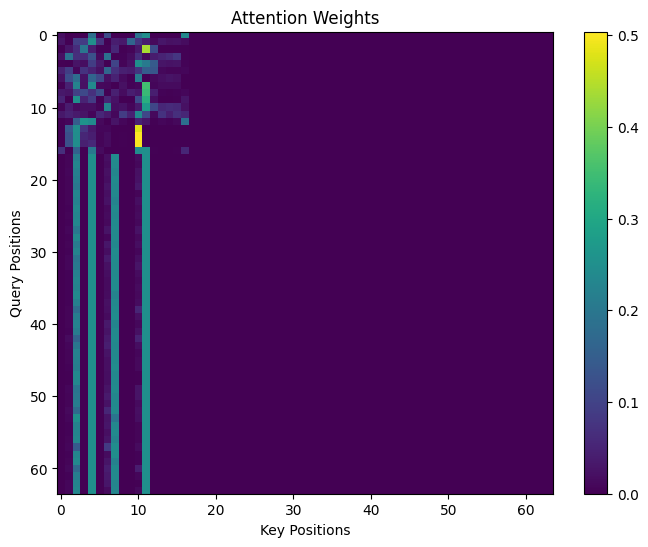

In [11]:
num_plots = 1
num_layers = len(model.attention_weights)
layers_to_plot = np.linspace(0, num_layers - 1, num_plots, dtype=int)

for layer_idx in layers_to_plot:
    plot_attention_weights(model.attention_weights, layer_idx)

# Summary

We,ve used BERT-tokenizer that performs subword tokenization. The heatmap illustrates that the model uses first 10-20 tokens. This seems viable as people tend to place the "summary" in first sentences. Note that we are dealing with twitter comments, which do not have any introductions.